# Moral Hazard
-  Do government policies affect (un)employment policies?
 - In economics, moral hazard occurs when an entity has an incentive to increase its exposure to risk because it does not bear the full costs of that risk. 

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels import regression

## Importing data

In [2]:
fundamentos = pd.read_csv(r'../data/complete_popularity_data.csv', sep=',', parse_dates=True, index_col=0)
fundamentos = fundamentos.sort_index(axis=0)
fundamentos

,mensal,presidente,positiva,regular,negativa,amostra,erro,nsnr,positiva_int,negativa_int,...,desocupacao,salario_real,ipca_mes,ipca_var_mensal,ipca_var_anual,Inflacao_acumulada,pib_var_mensal,pib_var_anual,ipca_no_ano,pib_no_ano
mes,,,,,,,,,,,,,,,,,,,,,
2011-01-31,2011-01,Dilma Rousseff I,0.510000,0.300000,0.070000,1000.000000,3.000000,12.000000,510,70,...,6.1,978.97,26.53,0.83,5.99,391.83,-6.34,15.32,0.83,-6.34
2011-02-28,2011-02,Dilma Rousseff I,0.510000,0.300000,0.070000,1000.000000,3.000000,12.000000,510,70,...,6.4,973.71,25.78,0.80,6.01,392.63,0.52,17.24,1.63,-5.82
2011-03-31,2011-03,Dilma Rousseff I,0.515000,0.305000,0.060000,1000.000000,2.100000,12.000000,515,60,...,6.5,976.28,25.66,0.79,6.30,393.42,3.85,11.62,2.42,-1.97
2011-04-30,2011-04,Dilma Rousseff I,0.515000,0.305000,0.060000,1000.000000,2.100000,12.000000,515,60,...,6.4,969.30,25.21,0.77,6.51,394.19,0.34,13.67,3.19,-1.63
2011-05-31,2011-05,Dilma Rousseff I,0.515000,0.305000,0.060000,1000.000000,2.100000,12.000000,515,60,...,6.4,963.81,15.51,0.47,6.55,394.66,4.93,15.91,3.66,3.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,2021-05,Jair Bolsonaro,0.268889,0.218111,0.493444,2089.666667,2.266667,1.787500,561,1031,...,14.6,1117.89,47.25,0.83,8.06,449.76,-1.05,22.65,3.18,1.51
2021-06-30,2021-06,Jair Bolsonaro,0.271213,0.208163,0.501875,1936.750000,2.462500,1.950000,525,972,...,14.1,1111.22,30.42,0.53,8.35,450.29,0.63,17.17,3.71,2.14
2021-07-31,2021-07,Jair Bolsonaro,0.254833,0.206333,0.521333,1926.500000,2.508333,1.733333,490,1004,...,14.7,1100.00,55.39,0.96,8.99,451.25,4.00,14.45,4.67,6.14


## Manipulating time series

In [7]:

fundamentos['gdp'] = fundamentos['pib'].apply(lambda x: x/1000)

fundamentos['lag'] = fundamentos['gdp'].shift()

fundamentos.dropna(inplace=True)

with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1. / .02, testval=.1)
    nu = pm.Exponential('nu', 1. / 10)
    beta = pm.GaussianRandomWalk('beta', sigma ** -2, shape=len(fundamentos['gdp']))
    observed = pm.Normal('observed', mu=beta * fundamentos['lag'], sd=1 / nu, observed=fundamentos['gdp'])

    trace = pm.sample(draws=1000, tune=1000, cores=2, return_inferencedata=True)

plt.plot(fundamentos.index,trace['beta'].T, 'b', alpha=.03)
plt.plot(fundamentos.index, 1 + (np.log(fundamentos['gdp']) - np.log(fundamentos['lag'])), 'r', label='True Growth Rate')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, nu, sigma]


RuntimeError: Chain 0 failed.

### Linear regression

In [7]:
def reg (X, Y):
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    return model.summary()

reg(fundamentos['positiva'], fundamentos['desocupacao'])

/Users/marcelino/miniconda3/envs/polls/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            desocupacao   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     131.8
Date:                Sun, 12 Sep 2021   Prob (F-statistic):           9.13e-26
Time:                        12:47:19   Log-Likelihood:                -670.16
No. Observations:                 321   AIC:                             1344.
Df Residuals:                     319   BIC:                             1352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1138      0.241     50.270      0.000      11.640      12.588
positiva      -6.6386      0.578    -11.480      0.000      -7.776      -5.501
==============================================================================
Omnibus:                        6.071   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                5.974
Skew:                           0.297   Prob(JB):                       0.0504
Kurtosis:                       2.695   Cond. No.                         6.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
reg(fundamentos['positiva'], fundamentos['igpm'])

/Users/marcelino/miniconda3/envs/polls/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   igpm   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.679
Date:                Sun, 12 Sep 2021   Prob (F-statistic):             0.0313
Time:                        12:48:44   Log-Likelihood:                -412.64
No. Observations:                 321   AIC:                             829.3
Df Residuals:                     319   BIC:                             836.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9390      0.108      8.691      0.000       0.726       1.152
positiva      -0.5608      0.259     -2.163      0.031      -1.071      -0.051
==============================================================================
Omnibus:                       95.109   Durbin-Watson:                   0.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.484
Skew:                           1.344   Prob(JB):                     9.17e-61
Kurtosis:                       6.667   Cond. No.                         6.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
reg(fundamentos['positiva'], fundamentos['cambio'])

/Users/marcelino/miniconda3/envs/polls/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cambio   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     62.98
Date:                Sun, 12 Sep 2021   Prob (F-statistic):           3.58e-14
Time:                        12:49:29   Log-Likelihood:                -459.51
No. Observations:                 321   AIC:                             923.0
Df Residuals:                     319   BIC:                             930.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3570      0.125     26.851      0.000       3.111       3.603
positiva      -2.3810      0.300     -7.936      0.000      -2.971      -1.791
==============================================================================
Omnibus:                       40.700   Durbin-Watson:                   0.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.806
Skew:                           0.868   Prob(JB):                     1.26e-12
Kurtosis:                       4.041   Cond. No.                         6.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
reg(fundamentos['positiva'], fundamentos['epu'])

/Users/marcelino/miniconda3/envs/polls/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    epu   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     36.90
Date:                Sun, 12 Sep 2021   Prob (F-statistic):           3.53e-09
Time:                        12:50:23   Log-Likelihood:                -1886.9
No. Observations:                 321   AIC:                             3778.
Df Residuals:                     319   BIC:                             3785.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        197.1303     10.669     18.477      0.000     176.139     218.121
positiva    -155.5395     25.604     -6.075      0.000    -205.914    -105.165
==============================================================================
Omnibus:                      111.916   Durbin-Watson:                   0.603
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.484
Skew:                           1.542   Prob(JB):                     9.66e-81
Kurtosis:                       7.247   Cond. No.                         6.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Graphics 

<ipython-input-35-29a5c6d4877a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = ['5   ', '7   ', '9   ', '11   ', '12   ', '14   ', '16%'])
<ipython-input-35-29a5c6d4877a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30   ', '40   ', '50   ', '60   ', '70   ', '80   ', '90%'])


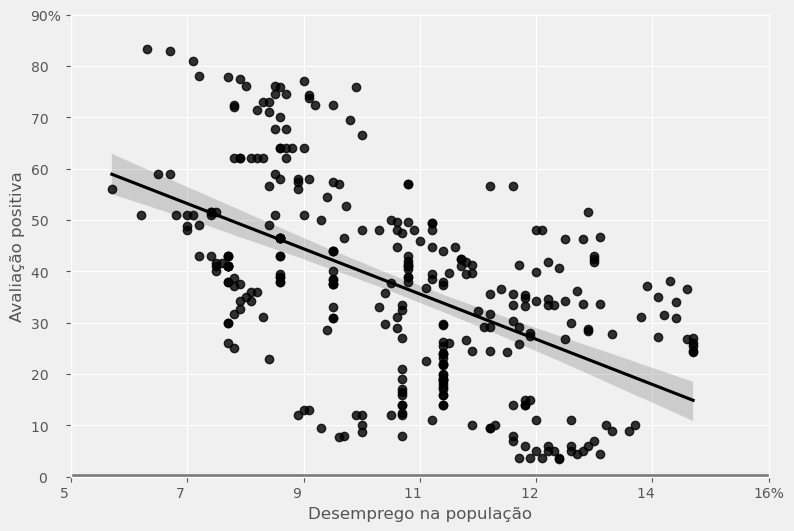

In [35]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(9, 6), facecolor="#f0f0f0")
ax.set_facecolor("#f0f0f0")
sns.regplot(data=fundamentos, 
            x='desocupacao',
            y='positiva',
            color = 'black') #    
ax.set_ylim(0, .90)
ax.set_xlim(4, 16)
ax.set_xticklabels(labels = ['5   ', '7   ', '9   ', '11   ', '12   ', '14   ', '16%'])
ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30   ', '40   ', '50   ', '60   ', '70   ', '80   ', '90%'])
ax.axhline(y = 0, color = 'black', linewidth = 4, alpha = .5)
# ax.text(x = 13, y = -.1, s = ' ©JOTA Labs', fontsize = 14, color = '#7F7F7F', backgroundcolor = '#f0f0f0');
plt.ylabel('Avaliação positiva')
plt.xlabel('Desemprego na população')
plt.show()


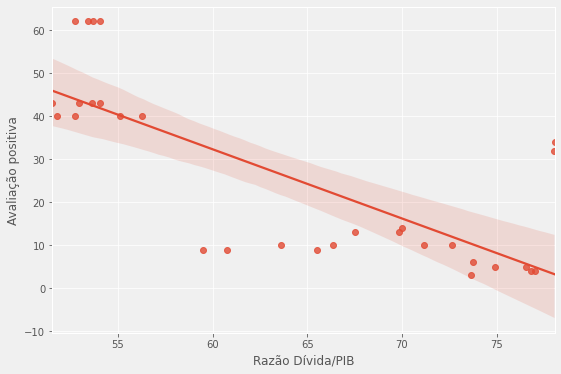

In [114]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(9, 6), facecolor="#f0f0f0")
ax.set_facecolor("#f0f0f0")
sns.regplot(data=serieI, 
            x='Dívida/PIB',
            y='POSITIVA')
plt.ylabel('Avaliação positiva')
plt.xlabel('Razão Dívida/PIB')
plt.show()

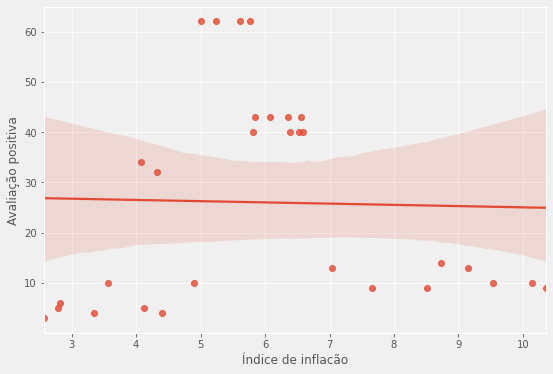

In [113]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(9, 6), facecolor="#f0f0f0")
ax.set_facecolor("#f0f0f0")
sns.regplot(data=serieI, 
            x='Inflação',
            y='POSITIVA')
plt.ylabel('Avaliação positiva')
plt.xlabel('Índice de inflacão')
plt.show()

In [18]:
# hide
def governo(data):
    data = data.date()
    if data >= datetime.date(1995, 1, 1) and data <= datetime.date(1998, 12, 31):
        return 'FHC 1'
    elif data >= datetime.date(1999, 1, 1) and data <= datetime.date(2002, 12, 31):
        return 'FHC 2'
    elif data >= datetime.date(2003, 1, 1) and data <= datetime.date(2006, 12, 31):
        return 'LULA 1'
    elif data >= datetime.date(2007, 1, 1) and data <= datetime.date(2010, 12, 31):
        return 'LULA 2'
    elif data >= datetime.date(2011, 1, 1) and data <= datetime.date(2014, 12, 31):
        return 'DILMA 1'
    elif data >= datetime.date(2015, 1, 1) and data < datetime.date(2016, 5, 12):
        return 'DILMA 2'
    elif data >= datetime.date(2016, 5, 12) and data <= datetime.date(2016, 12, 31):
        return 'TEMER'
    elif data >= datetime.date(2019, 1, 1) and data <= datetime.date(2022, 12, 31):
        return 'BOLSONARO'
    else:
        return None

    
fundamentos['governo'] = fundamentos.index.map(governo)

In [20]:
# A seguir os retornos do índice são calculados (dolar_d) e deflacionados (dolar_d_defl)

fundamentos["dolar_d"] = fundamentos["cambio"].diff()/fundamentos["cambio"].shift(1)
fundamentos["dolar_d_defl"] = (1 + fundamentos["dolar_d"])/(1 + fundamentos["igpm"]/100) - 1
fundamentos.head()

,mensal,presidente,positiva,regular,negativa,amostra,erro,nsnr,positiva_int,negativa_int,...,igpm,divida_publica,cambio,pib,pme,desocupacao,salario_real,governo,dolar_d,dolar_d_defl
mes,,,,,,,,,,,,,,,,,,,,,
1995-01-31,1995-01,Fernando Henrique I,0.570,0.2300,0.090,1000.0,3.0,10.00,570,90,...,0.92,29.35,0.85,47028.6,NaN,9.799259,404.57,FHC 1,NaN,NaN
1995-02-28,1995-02,Fernando Henrique I,0.570,0.2300,0.090,1500.0,2.5,10.00,854,135,...,1.39,29.43,0.84,49954.5,NaN,9.799259,400.53,FHC 1,-0.011765,-0.025313
1995-03-31,1995-03,Fernando Henrique I,0.415,0.4075,0.125,1300.0,2.5,5.25,539,162,...,1.12,28.92,0.89,60024.3,NaN,9.799259,394.14,FHC 1,0.059524,0.047789
1995-04-30,1995-04,Fernando Henrique I,0.390,0.4000,0.170,2000.0,3.0,3.00,780,340,...,2.10,28.67,0.91,57789.5,NaN,9.799259,384.56,FHC 1,0.022472,0.001442
1995-05-31,1995-05,Fernando Henrique I,0.380,0.4250,0.155,1600.0,3.0,3.50,608,248,...,0.58,28.11,0.90,56350.5,NaN,9.799259,538.08,FHC 1,-0.010989,-0.016692


In [25]:
# Vamos calcular o retorno acumulado passando a função aggregate a função de retorno acumulado abaixo, 
# que realiza o produtório do fator de captalização dos retornos, multiplicado por 100 para obter o número em percentual.
def sort_by_governo(dx):
    governos = ['FHC 1', 'FHC 2', 'LULA 1', 'LULA 2', 'DILMA 1', 'DILMA 2', 'TEMER', 'BOLSONARO']
    mapping = {gov: i for i, gov in enumerate(governos)}
    key = dx.index.map(lambda x: mapping[x])
    return dx.iloc[key.argsort()]

df_gov = fundamentos.groupby('governo')

df_gov_agg = df_gov[['dolar_d', 'dolar_d_defl']].aggregate(lambda x: 100*(np.prod(1 + x) - 1))

df_gov_agg = sort_by_governo(df_gov_agg).round(2)

df_gov_agg

,dolar_d,dolar_d_defl
governo,,
FHC 1,42.35,4.11
FHC 2,200.00,64.26
LULA 1,-40.77,-53.88
LULA 2,-21.40,-39.28
DILMA 1,56.21,26.02
DILMA 2,35.23,18.41
TEMER,-6.16,-9.56
BOLSONARO,35.31,-12.88


As colunas dolar_d e dolar_d_defl representam os retornos totais nos períodos dos governos federais. Já é possível notar duas coisas: o primeiro governo do FHC2 apresenta um retorno muito grande e enquanto os governos Lula 1 e 2 apresentam um retorno bem menor.

Populating the interactive namespace from numpy and matplotlib


<AxesSubplot:title={'center':'Variação % do Dólar nos Governos Federais'}, xlabel='Governo', ylabel='Variação (%)'>

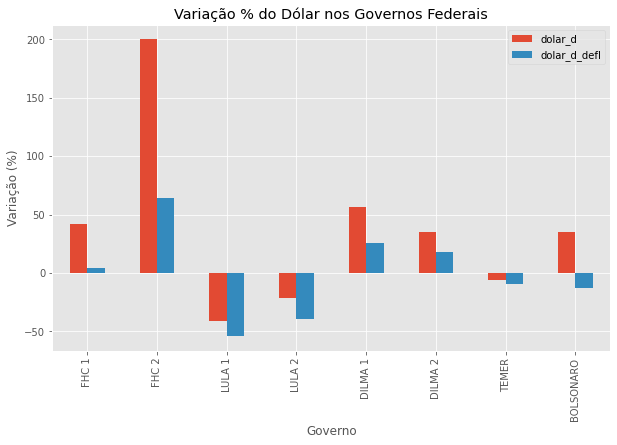

In [26]:
%pylab inline

ax = df_gov_agg[['dolar_d', 'dolar_d_defl']].plot(kind='bar', figsize=(10,6),
                                                          title="Variação % do Dólar nos Governos Federais")
ax.set_xlabel("Governo")
ax.set_ylabel("Variação (%)");

ax

É possível observar diversas coisas, vou listar os pontos que mais me chamaram a atenção:

A inflação no governo LULA 1 e 2 comeu todo o retorno obtido com a variação do dólar, o período Lula 2 contempla a crise do Sub Prime.
O pior período para o dólar foi o primeiro governo de LULA
O governo FHC 2 apresentou um retorno espetacular
Os governos DILMA 1 e 2 apresentam retornos semelhantes.
No entanto, os governos DILMA 2 e TEMER possuem durações diferentes dos demais, portanto vamos calcular os retornos anualizados para cada governo para facilitar a comparação. Apesar de que governos com maiores durações sofrem mais com a volatilidade do que governos mais curtos, que por outro lado tem menos tempo de recuperação caso recessões ocorram.

In [28]:
df_gov_agg['Meses'] = df_gov['governo'].count()
df_gov_agg

,dolar_d,dolar_d_defl,Meses
governo,,,
FHC 1,42.35,4.11,48
FHC 2,200.00,64.26,48
LULA 1,-40.77,-53.88,48
LULA 2,-21.40,-39.28,48
DILMA 1,56.21,26.02,48
DILMA 2,35.23,18.41,16
TEMER,-6.16,-9.56,8
BOLSONARO,35.31,-12.88,33


Os retornos anualizados são calculados a partir dos retornos do período, de acordo com a fórmula:

$$((1+r)^{12/n}−1) \times 100$$

onde $r$ são as taxas de retorno e $n$ é a quantidade de meses de cada governo.

In [29]:
df_gov_agg['dolar_d_anual'] = ((1 + df_gov_agg['dolar_d']/100)**(12./df_gov_agg['Meses']) - 1)*100
df_gov_agg['dolar_d_defl_anual'] = ((1 + df_gov_agg['dolar_d_defl']/100)**(12./df_gov_agg['Meses']) - 1)*100
df_gov_agg

,dolar_d,dolar_d_defl,Meses,dolar_d_anual,dolar_d_defl_anual
governo,,,,,
FHC 1,42.35,4.11,48,9.229355,1.012033
FHC 2,200.00,64.26,48,31.607401,13.209521
LULA 1,-40.77,-53.88,48,-12.272565,-17.591440
LULA 2,-21.40,-39.28,48,-5.842344,-11.725973
DILMA 1,56.21,26.02,48,11.796243,5.952173
DILMA 2,35.23,18.41,16,25.402093,13.511872
TEMER,-6.16,-9.56,8,-9.096208,-13.991608
BOLSONARO,35.31,-12.88,33,11.623677,-4.890329


Populating the interactive namespace from numpy and matplotlib


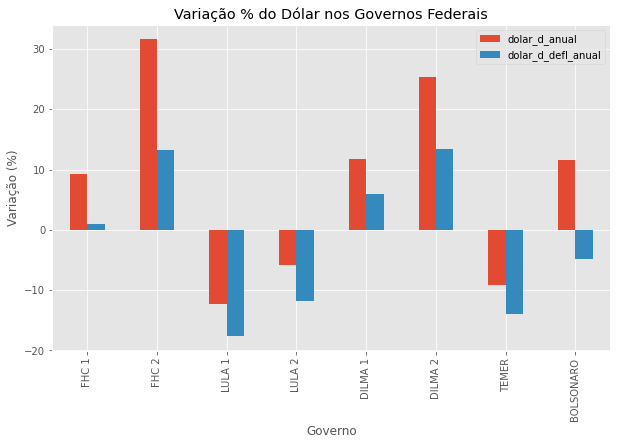

In [31]:
%pylab inline
ax = df_gov_agg[['dolar_d_anual', 'dolar_d_defl_anual']].plot(kind='bar', figsize=(10,6),
                                                                      title="Variação % do Dólar nos Governos Federais")
ax.set_xlabel("Governo")
ax.set_ylabel("Variação (%)");

Os dados anualizados produzem uma mudança de escala significativa onde o governo LULA 1 ainda apresenta o pior período para o dólar, entretanto o governo TEMER também aparece em destaque. Por outro lado, o governo FHC 2 continua liderando como melhor período de retornos exepcionais, mas ganha destaque também o governo DILMA 2 que em meio a crise de governabilidade trouxe retornos semelhante (descontado da inflação) ao observado no governo FHC 2.

### Others graphics

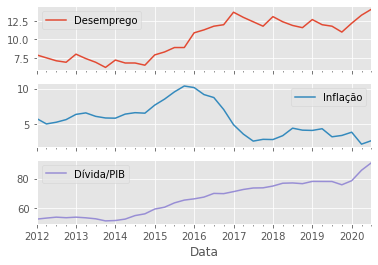

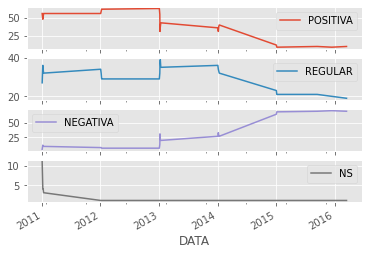

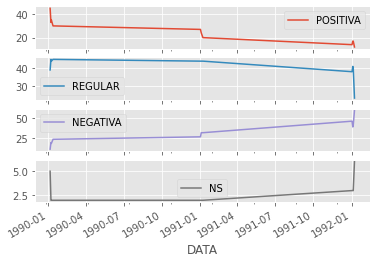

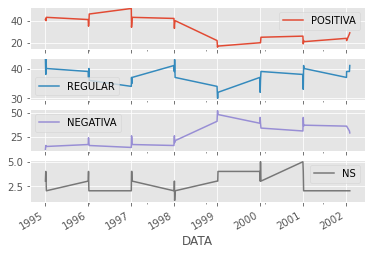

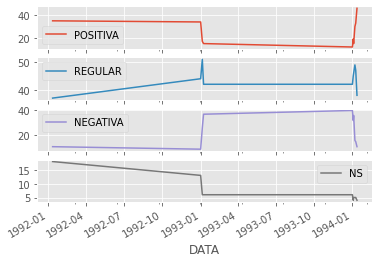

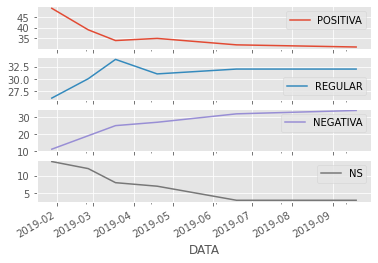

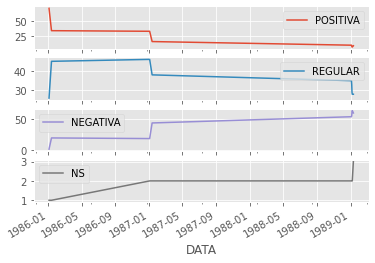

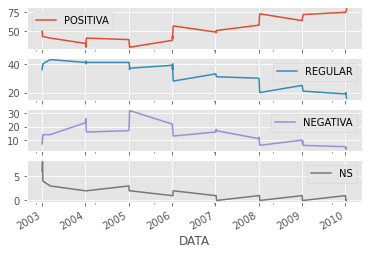

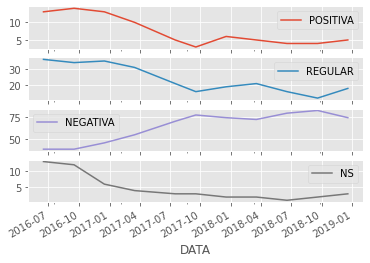

In [108]:
macro.plot(subplots=True)
plt.show()


pop.groupby('PRESIDENTE').plot(subplots=True)
plt.show()